In [1]:
import gym
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from collections import defaultdict
from numba import njit
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

#from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

OPEN AI GYM BlackJack
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

## First-visit Monte Carlo по состояниям


In [2]:
def policy19(observation):
    score, dealer_score, usable_ace = observation
    hit = 1
    stick = 0
    return stick if score >= 19 else hit

In [3]:
def run_episode(pi, env):
    observation = env.reset() 
    states, actions, rewards = [], [], []
    while True:
        states.append(observation)
        action = pi(observation)
        actions.append(action)
        
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
              break
    return states, actions, rewards

def estimate_policy_func(env, policy, total_episodes):
    total_reward = 0
    for _ in range(total_episodes):
        states, _, rewards = run_episode(policy, env)
        reward = rewards[-1]
        total_reward += reward
    
    return total_reward / total_episodes

def run_episode_with_policy(pi, env):
    observation = env.reset() 
    states, actions, rewards = [], [], []
    while True:
        states.append(observation)
        action = pi.get(observation)
        if action is None:
            #action = 0 if observation[0] >= 19 else 1
            action = np.random.choice(np.arange(nA))
        actions.append(action)
        
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
              break
    return states, actions, rewards


def get_reward_episode(pi, env):
    states, _, rewards = run_episode_with_policy(pi, env)
    return rewards[-1]

def estimate_policy(env, policy, total_episodes, counting=False):
    if counting:
        env = bj2.BlackjackEnvV2()
    total_reward = 0
    for _ in range(total_episodes):
        reward = get_reward_episode(policy, env)
        total_reward += reward
    
    return total_reward / total_episodes



def update_returns(N, states,rewards, value_table):
    returns = 0

    for t in range(len(states) -1, -1, -1):
        R = rewards[t]
        S = states[t]
        returns += R

        if S not in states[:t]:
            N[S] += 1
            value_table[S] += (returns - value_table[S]) / N[S]
    

In [4]:
def first_visit_mc_prediction(policy, env, total_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    for _ in range(total_episodes):
        states, _, rewards = run_episode(policy, env)
        update_returns(N, states, rewards, value_table)

    return value_table

In [5]:
env = gym.make('Blackjack-v0')
value = first_visit_mc_prediction(policy19, env, total_episodes=500000)   

In [6]:
money0 = estimate_policy_func(env, policy19, 100000)
money0

-0.20077

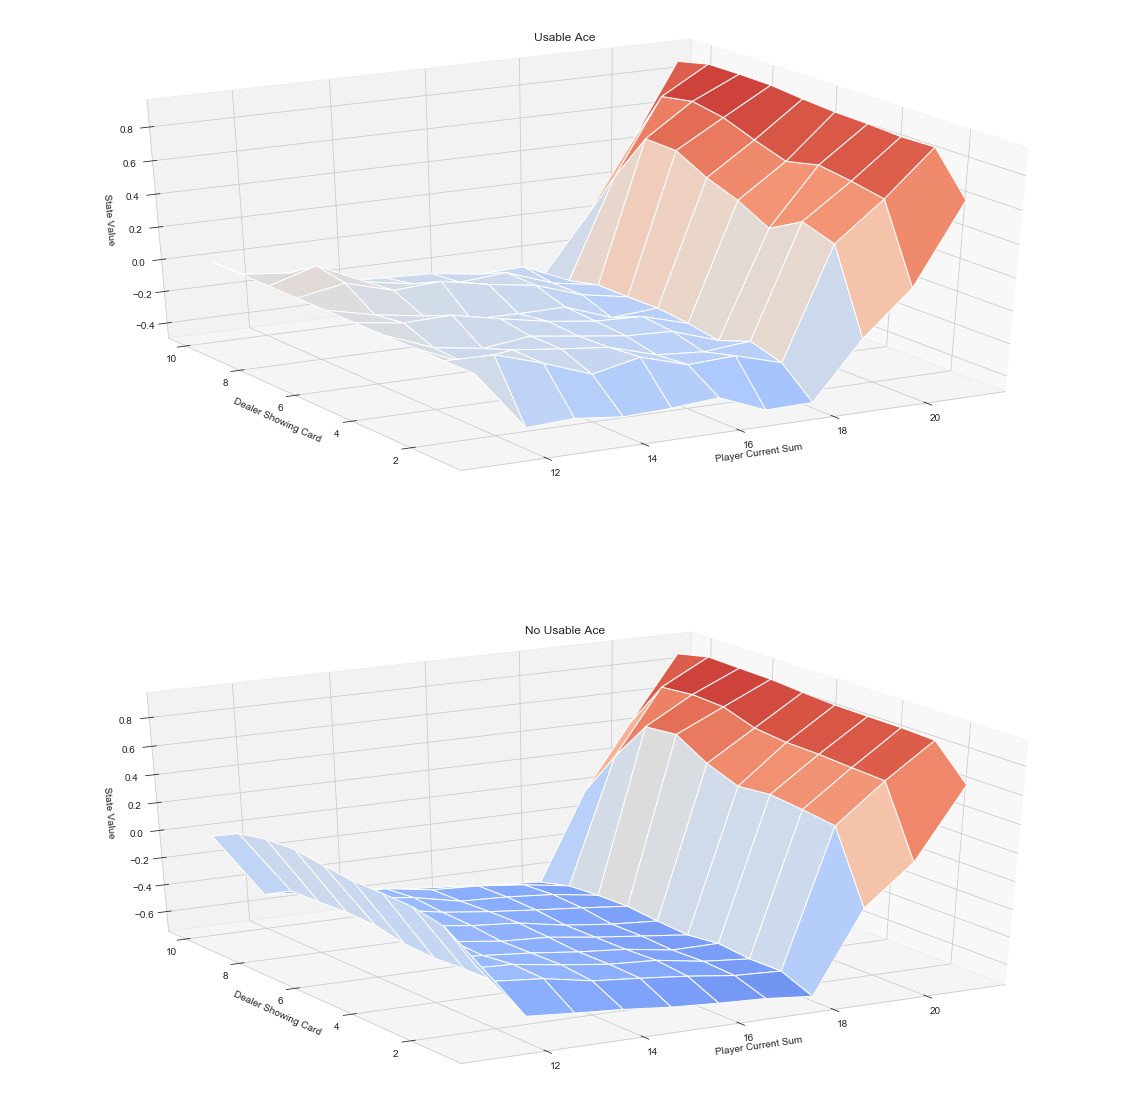

In [26]:
def plot_blackjack(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Current Sum')
        ax.set_ylabel('Dealer Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

plot_blackjack(value)

## Monte-Carlo control с on-policy исследованием

In [8]:
def compute_episode_by_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        if state in Q:
            action = np.random.choice(np.arange(nA), p=get_probs_policy(Q[state], epsilon, nA))
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs_policy(Q, epsilon, nA):
    policy = np.ones(nA) * epsilon / nA
    policy[np.argmax(Q)] = 1 - epsilon + (epsilon / nA)
    return policy

def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    g = 0
    for i, state in enumerate(states):
        Q_prev = Q[state][actions[i]] 
        Q[state][actions[i]] = Q_prev + alpha*(sum(rewards[i:]*discounts[:-(i+1)]) - Q_prev)
    return Q

In [9]:
def compute_policy_by_Q(Q):
    return dict((k, np.argmax(v)) for k, v in Q.items())

def mc_control_on_policy(env, num_episodes, alpha, gamma=1.0, init_episodes = 20000, 
                         eps_start=1.0, eps_decay=.99999, eps_min=0.05, counting=False):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    eps = eps_start
    mean_reward = []
    for i_episode in tqdm.tqdm(range(1, num_episodes+1)):
        eps = max(eps * eps_decay, eps_min)
        episode = compute_episode_by_Q(env, Q, eps, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        if i_episode < init_episodes:
            continue
        if i_episode % 10000 == 0:
            cur_policy = compute_policy_by_Q(Q)
            cur_estimation = estimate_policy(env, cur_policy, 100000, counting)
            mean_reward.append(cur_estimation)
            
    policy = compute_policy_by_Q(Q)
    return policy, Q, mean_reward

In [10]:
env = gym.make('Blackjack-v0')
policy, Q, mean_reward = mc_control_on_policy(env, 10000000, 0.02, init_episodes=200000)

100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [54:51<00:00, 3037.88it/s]


In [11]:
mean_money = estimate_policy(env, policy, 500000)
mean_money

-0.05529

Text(0.5, 1.0, 'Mean reward from policy')

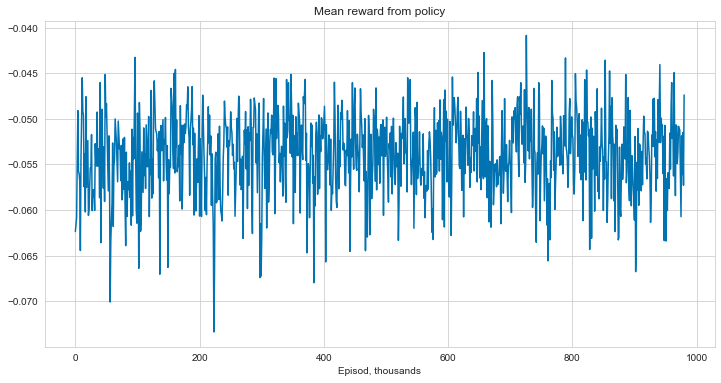

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_reward)
ax.set_xlabel('Episod, thousands')
ax.set_title('Mean reward from policy')

# Часть вторая, удвоенная

In [13]:
import blackjack_v1 as bj1

In [14]:
env1 = bj1.BlackjackEnvV1()
print(env1.reset())

(9, 9, False)


In [15]:
policy1, Q1, mean_reward1 = mc_control_on_policy(env=env1,num_episodes=10000000, alpha=0.02, init_episodes=200000)

100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [55:03<00:00, 3026.88it/s]


In [16]:
money1 = estimate_policy(env1, policy1, 500000)
money1

-0.04421

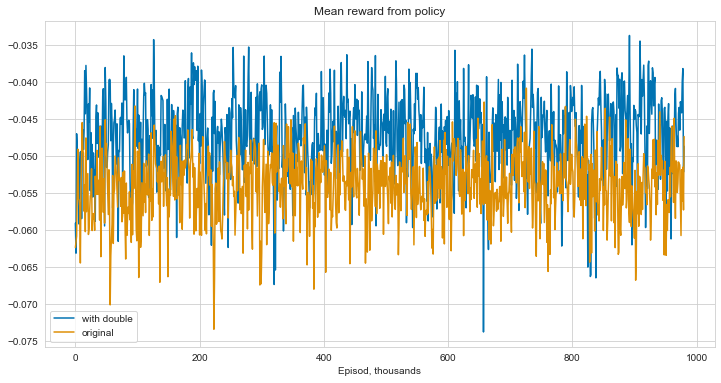

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_reward1, label='with double')
ax.plot(mean_reward,label='original')
ax.set_xlabel('Episod, thousands')
ax.set_title('Mean reward from policy')
ax.legend()

## Часть третья, в главной роли — Дастин Хоффман

In [18]:
import blackjack_v2 as bj2

In [19]:
#не используются
def correct_probs_with_counting(action_probs, delta):
    delta *= 4
    new_action_probs = [action_probs[0] + delta/2, action_probs[1] - delta, action_probs[2] + delta/2]
    return new_action_probs

def run_episode_with_policy_with_counting(Q, env):
    observation = env.reset() 
    states, actions, rewards = [], [], []
    while True:
        states.append(observation)
        action_probs = Q[observation]
        count_delta = env.get_count_decks()
        new_action_probs = correct_probs_with_counting(action_probs, count_delta)

        action = np.argmax(new_action_probs)
        actions.append(action)
        
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
              break
    return states, actions, rewards


def get_reward_episode_by_Q(Q, env):
    states, _, rewards = run_episode_with_policy_with_counting(Q, env)
    return rewards[-1]

def estimate_policy_by_Q(env, Q, total_episodes):
    total_reward = 0
    for _ in range(total_episodes):
        reward = get_reward_episode_by_Q(Q, env)
        total_reward += reward
    
    return total_reward / total_episodes

In [20]:
env2 = bj2.BlackjackEnvV2()
policy2, Q2, mean_reward2 = mc_control_on_policy(env2, 10000000, 0.02, init_episodes=200000,counting=True)


100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [37:20<00:00, 4463.85it/s]


In [21]:
money2 = estimate_policy(env2, policy2, 500000, True)
money2

-0.045294

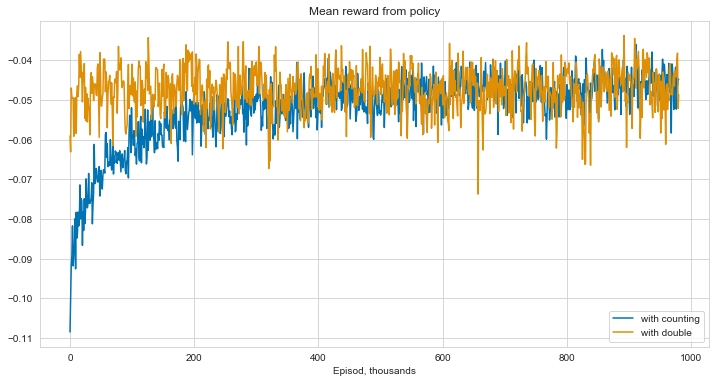

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_reward2, label='with counting')
ax.plot(mean_reward1, label='with double')
#ax.plot(mean_reward,label='original')
ax.set_xlabel('Episod, thousands')
ax.set_title('Mean reward from policy')
ax.legend()